# Chaper 4. 모델 훈련

이 장에서는 **신경망**(neural network)을 이해하고 구축하고 훈련시키는 것을 배우도록 하겠습니다!

가장 간단한 모델인 **선형 회귀**부터 시작하겠습니다. 이 모델을 훈련시키는 데에는 두가지 방법이 있습니다.

1. 직접 계산할 수 있는 공식을 사용하여 훈련 세트에 가장 잘 맞는 모델 파라미터를 해석적으로 구합니다.
2. 경사하강법이라 불리는 최적화 방식을 사용해 모델 파라미터를 조금씩 바꾸면서 비용 함수를 훈련 세트에 대해 최소화시킵니다.

그 다음에는 비선형 데이터셋에 훈련시킬 수 있는 조금 더 복잡한 모델인 다향 회귀를 살펴보도록 하겠습니다!

## 1. 선형 회귀

회귀 모델은 아래와 같이 나타낼 수 있습니다.

$$ \hat y = h_{\theta}(x) = {\theta}^T \times x$$

- ${\theta}^T$는 $\theta$의 전치함수입니다.
- $x$는 샘플들의 특성 벡터입니다
- $h_{\theta}$는 모델 파라미터 $\theta$에 사용한 가설 함수입니다.

여기서 살펴보시면, x는 주어지는 값입니다. 그러면 우리는 오차가 최대한 적게 나오는 $\theta$를 찾는 것이 목표겠죠? 

### 1.1 정규 방정식

비용 함수를 최소로 하는 $\theta$를 찾기 위한 해석적인 방법이 있습니다. 다른 말로 하면 바로 결과를 얻을 수 있는 수학 공식이 있습니다. 이를 **정규 방정식**이라고 합ㅂ니다. 

$$\hat{\theta} = (X^T \times X)^{-1} \times y$$

- $\hat{\theta}$는 비용 함수를 최소화하는 $\theta$값입니다.
- y는 $y^{(1)}$부터 $y^{(m)}$까지 포함하는 타깃 벡터입니다. 

이 공식을 테스트하기 위해 선형처럼 보이는 데이터를 생성하도록 하겠습니다.

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

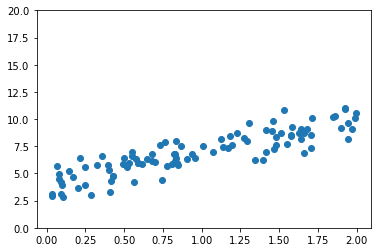

In [3]:
import matplotlib.pyplot as plt

plt.scatter(X, y)
plt.ylim([0, 20])

plt.show()

이제 정규 방정식을 사용해서 $\hat\theta$를 계산해보겠습니다. 넘파이 선형대수 모듈(`np.linalg`)에 있는 `inv()`함수를 사용해 역행렬을 계산하고 `dot()` 메서드를 사용해 행렬 곱셈을 하겠습니다.

In [4]:
X_b = np.c_[np.ones((100, 1)), X] # 모든 샘플에 x0 = 1을 추가합니다
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

이 데이터를 생성하기 위해 사용한 실제 함수는 $y = 4 + 3x_1 + 가우시안 노이즈$입니다. 정규 방정식으로 계산한 값을 확인해보겠습니다.

In [5]:
theta_best

array([[4.03694504],
       [2.96754035]])

오, 비슷하게 나오네요! $\theta_0$는 4와 $\theta_1$은 3을 기대했었습니다. 매우 비슷하지만 노이즈 때문에 원래 함수의 파라미터를 정확하게 재현하지는 못했네요. 

$\hat\theta$을 사용해 예측해보겠습니다.

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.03694504],
       [9.97202574]])

모델의 예측을 그래프로 나타내보겠습니다.

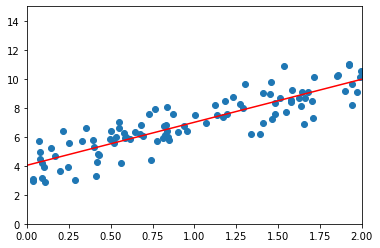

In [7]:
plt.plot(X_new, y_predict, "r-")
plt.scatter(X, y)
plt.axis([0, 2, 0, 15])
plt.show()

같은 작업을 하는 사이킷런 코드는 다음과 같습니다.

In [8]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.03694504]), array([[2.96754035]]))

여기서 `lin_reg.intercept_`는 편향(bias), `lin_coef_`는 가중치를 의미합니다. 사이킷런은 특성의 가중치와 편향을 분리해서 저장하고 있습니다.

In [9]:
lin_reg.predict(X_new)

array([[4.03694504],
       [9.97202574]])

### 1.2 계산 복잡도

정규 방정식은 특성수가 매우 많아지면 매우 느려집니다. 

정규방정식에서는 $(n+1)\times(n+1)$ 크기가 되는 $X^T \times X$를 계산해야하는데, 특성수가 늘어날수록 계산 복잡도가 엄청나게 늘어나게 됩니다. 예측하려는 샘플이 늘어나면 또 그만큼 걸리는 시간도 엄청나게 느려지죠.

이제 다른 방법을 한번 살펴봅시다! 바로 경사 하강법입니다. 
이 방법은 특성이 아주 많고 훈련 샘플이 너무 많아 메모리에 모두 담을 수 없을 때 적합합니다. 

## 2. 경사 하강법

**경사 하강법**(gradient descent)는 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 매우 일반적인 최적화 알고리즘입니다.

경사하강법은 비용함수를 최소화 하기 위해 반복적으로 파라미터를 조절해가는 방법입니다. 비용함수가 최저가 되는 지점에서의 값을 선택하는 것이죠.

<img src = "'https://file.okky.kr/images/1563694641970.PNG" />


아주 유명한 그림이죠? 대부분 잘 알고 계실거라 생각합니다.

**중요한 몇가지 포인트**
1. 학습률 : 하이퍼 파리미터로, 얼마나 전진할지에 대한 값입니다. 학습률이 너무 작으면 알고리즘이 반복을 많이해야하므로 시간이 오래 걸립니다.
2. 방향 : 경사가 줄어드는 방향으로 계속해서 움직이게 됩니다. 

1과 2가 매우 중요하다보니 관련해서 다양한 옵티마이저 함수들이 있죠. 그것들에 대해서는 차차 알아봅시다!


## 3. 다향 회귀

가지고 있는 데이터가 단순한 직선보다 복잡한 형태라면 어떨까요? 

이럴 경우에는 선형 모델에 약간의 가공(activation function)을 통해서 비선형으로 예측할 수 있게 합니다. 이런 확장된 특성을 포함한 데이터셋에 훈련시키는 방법을 **다향 회귀**(polynominal regression)이라고 합니다.

한번 예시를 살펴봅시다. 간단한 2차방정식으로 비선형 데이터를 생성하겠습니다.

In [10]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

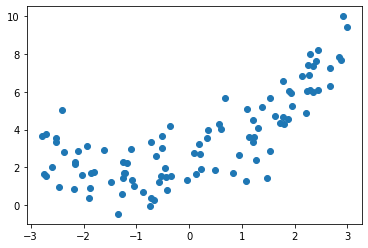

In [11]:
plt.scatter(X, y)

이제 더이상 직선의 형태를 보이지 않습니다! 그렇다면 선형 모델에서는 잘 되지 않겠죠.

사이킷런의 `PolynominalFeatures`를 사용해 훈련 데이터를 변환해보도록 하겠습니다. 훈련 세트에 있는 각 특성을 제곱(2차 다항)하여 새로운 특성으로 추가합니다.

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias = False) 
X_poly = poly_features.fit_transform(X)
X[0]

array([-2.74037945])

In [13]:
X_poly[0]

array([-2.74037945,  7.50967953])

`X_poly`에서는 기존의 값과 함께 이 특성의 제곱을 포함합니다. 

이 확장된 훈련 데이터에 `LinearRegression`을 포함시켜보도록 하겠습니다.

In [14]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.12621896]), array([[0.92523764, 0.43286587]]))

나쁘지 않습니다. 

특성이 여러개일 때 다향 회귀는 이 특성 사이의 관계를 찾을 수 있습니다. `PolynomialFeatures`가 주어진 차수까지 특성 간의 모든 교차항을 추가하기 때문입니다. 예를 들어 두 개의 특성 a, b가 있을 때 degree=3으로 `PolynomialFeatures`를 적용하면 $a^2$, $a^3$, $b^2$, $b^3$ 등 뿐만 아니라 $ab$, $a^2b$, $ab^2$ 등도 특성으로 추가합니다.

## 4. 학습 곡선

고차 다항 회귀를 이용하면 보통의 선형 회귀에서보다 훨씬 더 훈련 데이터 잘 맞추려 할 것입니다. 그러다보면 과적합이 되는 경우가 잦습니다.
이전 장에서는 모델을 일반화 한 성능을 찾기 위해 **교차 검증**을 사용했습니다. 또 다른 방법으로는 **학습 곡선**을 살펴보는 것입니다. 

학습 곡선은 훈련 세트와 검증 세트의 모델 성능을 훈련 세트의 크기의 함수로 나타냅니다. 이 그래프를 생성하기 위해서는 단순히 훈련 세트에서 크기다 다른 서브 세트를 만들어 모델을 여러번 훈련시키면 됩니다.

아래 코드는 주어진 훈련 데이터에서 모델의 학습 곡선을 그리는 함수를 정의합니다.

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train set")
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label="validation set")
    plt.legend()

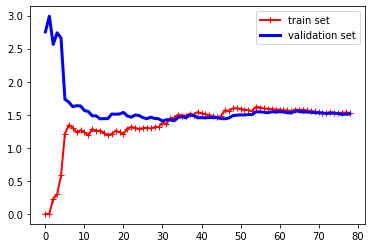

In [16]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

그림을 다시 한번 살펴봅시다. 

먼저 훈련 데이터입니다. 그래프가 0에서 시작하므로 훈련 세트에서 하나 혹은 두개의 샘플이 있을 때에는 완벽하게 작동합니다. 하지만 훈련 세트에 샘플이 추가됨에 따라 노이즈도 있고 비선형이기 때문에 모델이 훈련 데이터를 완벽하게 학습하는 것이 불가능해집니다. 그래서 곡선이 어느정도 평평해질 때 까지 오차가 계속 증가하게 됩니다. 

다음으로는 검증 데이터입니다. 검증 데이터의 경우네는 모델이 적은 수의 샘플로 훈련하게 되어 제대로 일반화될 수 없어 초기에는 오차가 매우 큽니다. 모델에 훈련 샘플이 추가됨에 따라 점차 학습이 되면서 검증 오차가 줄어들게됩니다. 

이 학습 곡선이 과소적합 모델의 전형적인 모습입니다. 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해있습니다.

이제 같은 데이터에서 10차 다항 회귀 모델의 학습 곡선을 그려봅시다.

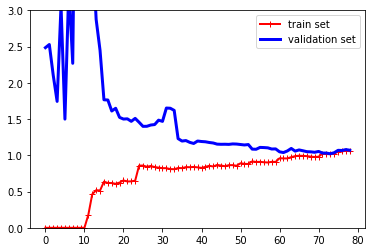

In [17]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)
plt.ylim([0, 3])
plt.show()

이 학습 곡선은 위와 비슷해보이지만 몇가지 차이점이 있습니다.

1. 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮습니다.
2. 두 곡선 사이에 공간이 있습니다. 이 말은 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낮다는 것이므로, 과대적합의 모델일 가능성이 큽니다. 

## 5. 규제가 있는 선형 모델

1장과 2장에서 보았듯이 과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것입니다. 자유도를 줄이면 데이터에 과대적합 되기 더 어려워집니다. 예를 들어 다향회귀모델을 규제하는 간단한 방법은 **다항식의 차수를 감소시키는 것**입니다.

선형 회귀모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가합니다. 각기 다른 방법으로 가중치를 제한하는 (1) 릿지 회귀, (2) 라쏘 회귀, (3) 엘라스틱넷을 살펴보겠습니다.

### 5.1 릿지 회귀

**릿지 회귀**(또는 **티호노프 규제**)는 규제가 추가된 선형 회귀 버전입니다. 규제항 $\alpha\sum_{i=1}^{n}\theta^2_i$이 비용함수에 추가됩니다. 이는 학습 알고리즘을 데이터에 맞추는 것 뿐만 아니라 모델의 가중치가 가능한 한 작게 유지되도록 노력합니다. 규제항은 훈련하는 동안에만 비용함수에 추가도비니다. 모델의 훈련이 끝나면 모델의 성능을 규제가 없는 성능 지표로 평가합니다.

하이퍼 파라미터 $\alpha$는 모델을 얼마나 많이 규제할지 조절합니다. $\alpha = 0$이면 릿지회귀는 선형회귀와 같아집니다. $\alpha$가 아주 크면 모든 가중치가 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선이 됩니다. 

아래는 릿지 회귀의 비용함수 입니다.

$$ J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum_{i=1}^{n}\theta_i^2 $$

편향 $\theta_0$는 규제되지 않습니다. (합 기호가 $i=0$이 아니고 $i=1$부터 시작합니다.) $w$를 특성의 가중치 벡터($\theta_1$부터 $\theta_n$)라고 정의하면 규제항은 $\frac{1}{2}{({||w||}_2)}^2$과 같습니다. 

## 6. 로지스틱 회귀

분류에서 자주 사용하는 알고리즘 중 하나는 바로 이 **로지스틱 회귀**입니다. 샘플이 특정 클래스에 속할 확률을 주정하는 데 널리 사용됩니다. 

### 6.1 확률 추정

그렇다면 실제로 어떻게 작동하는 걸까요? 선형 회귀 모델과 같이 로지스틱 회귀 모델은 입력 특성의 가중치 합을 계산합니다. 대신 선형 회귀처럼 바로 결과를 출력하지 않고 결과값의 **로지스틱**을 출력합니다.

아래는 로지스틱 회귀 모델의 확률 처정 방법입니다.

$$ \hat p = h_\theta (x) = \sigma(\theta^T \cdot x)$$

로지스틱(또는 *로짓*(logit)이라고 부르며 $\sigma(\cdot)$으로 표시합니다.) 은 0과 1 사이의 값을 출력하는 **시그모이드 함수**(sigmoid function)입니다. 이 함수는 아래와 같이 정의됩니다.

$$ \sigma(t) = \frac{1}{1 + exp(-t)} $$

로지스틱 회귀 모델이 샘플 x가 양성 클래스에 속할 확률 $\hat p = h_\theta (x)$를 추정하면 이에 대한 예측 $\hat y$를 쉽게 구할 수 있습니다.

$$ \hat y = \left \{ \begin{array}{cc}0 \quad \hat p < 0.5일\;때 \\1 \quad \hat p >= 0.5일\;때 \end{array} \right. $$

### 6.2 훈련 비용과 비용 함수

이제 로지스틱 회귀 모델이 어떻게 확률을 추정하고 예측하는지 알았습니다. 그럼 어떻게 훈련을 시킬까요?

훈련의 목적은 양성 샘플 ($y=1$)에 대해서는 높은 확률을 추정하고 음성 샘플 ($y=0$)에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터 $\theta$를 찾는 것입니다. 이러한 아이디어가 하나의 훈련 샘플 x에 대해 나타낸 비용 함수인 아래 식에 잘 나타나있습니다.

$$ c(\theta) = \left \{ \begin{array}{cc} -\log(\hat p) \quad y = 1일\; 때 \\-log(1-\hat p) \quad y=0일\; 때 \end{array} \right. $$

이 비용함수는 t가 0에 가까워지면 $-log(t)$가 매우 커지므로 타당하다 할 수 있습니다. 그러므로 모델이 양성 샘플을 0에 가까운 확률로 추정하면 비용이 크게 증가할 것입니다. 또한 음성 샘플을 1에 가까운 확률로 추정해도 비용이 증가살 것입니다. 반면 t가 1에 가까우면 $-log(t)$는 0에 가까워집니다. 따라서 기대한대로 음성 샘플의 확률을 0에 가깝게 추정하거나 양성 샘플의 확률을 1에 가깝게 추정하면 비용은 0에 가까워 질 것입니다.

전체 훈련 세트에 대한 비용 함수는 모든 훈련 샘플의 비용을 평균한 것입니다. 이를 로그 손실(log loss)라고 부릅니다.

### 6.3 결정 경계

로지스틱 회귀를 설명하기 위해 붓꽃 데이터를 사용해봅시다. 이 데이터 셋은 세개의 품종 (iris-setosa, iris-versicolor, iris-verginica)에 속하는 붓꽃 150개의 꽃잎과 꽃받침의 너비와 길이를 담고 있습니다.


In [18]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [19]:
X = iris["data"][:, 3:] # 꽃잎의 너비
y = (iris["target"]==2).astype(np.int) # 1 tiris-virginica면 1, 그렇지 않으면 0

로지스틱 회귀 모델을 훈련시킵시다

In [20]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver="liblinear")
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률을 계산해보겠습니다.

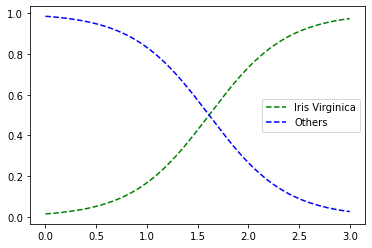

In [25]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g--", label="Iris Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Others")
plt.legend()
plt.show()

Iris-Virginica의 꽃잎의 너비는 1.4~2.5cm 분포에 위치합니다. 반면 다른 붓꽃은 일반적으로 꽃잎의 너비가 더 작은 부분에 위치합니다. 

양쪽의 확률이 같아지는 1.6cm 근방에서 *결정 경계*(detection boundary)가 만들어지네요. 꽃잎의 너비가 1.6cm보다 크면 분류기는 Iris Virginica, 작으면 아니라고 예측할 것입니다.

In [27]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

다른 선형모델처럼 로지스틱 회귀 모델도 $\mathscr{l_1}, \mathscr{l_2}$ 패널티를 사용하여 규제할 수 있습니다. 사이킷런은 $\mathscr{l_2}$ 패널티를 기본으로 합니다.

### 6.4 소프트맥스 회귀

로지스틱 회귀 모델은 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화할 수 있습니다. 이를 **소프트맥스 회귀** 또는 **다항 로지스틱 회귀**라고 합니다.

개념은 매우 간단합니다. 샘플 x가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 $k$에 대한 점수 $s_k(x)$를 계산하고 그 점수에 *소프트맥스 함수*(또는 **정규화된 지수 함수**라고 부릅니다.)를 적용하여 각 클래스의 확률을 추정합니다. $s_k(x)$를 계산하는 식은 선형 회귀 예측을 위한 식과 매우 비슷해서 친숙할 것입니다.

$$ s_k(x) = {(\theta^{(k})}^T \cdot x $$

각 클래스는 자신만의 파라미터 $\theta^{(k)}$가 있습니다. 이 벡터들은 **파라미터 행렬**에 행으로 저장됩니다. 

샘플 x에 대해 각 클래스의 점ㅈ수가 계산되면 소프트맥스 함수를 통과시켜 클래스 k에 속할 확률 $\hat p_k$를 추정할 수 있습니다. 이 함수는 각 점수에 지수 함수를 적용한 후 정규화합니다.

$$ \hat p_k = \sigma{(s(x))}_k = \frac{exp(s_k(x)}{\sum_{j=1}^{K} exp(s_j(x))} $$

- K는 클래스 수입니다.
- $s(x)$는 샘플 x에 대한 각 클래스의 점수를 담고있는 벡터입니다.
- $\sigma{(s(x))}_k$는 샘플 x에 대한 각 클래스의 점수가 주어졌을 때 이 샢플이 클래스 k에 속할 추정 확률입니다.

소프트맥스 회귀 분류기는 <u>추정 확률이 가장 높은 클래스를 선택</u>합니다.


---

#### 훈련 방법

모델이 어떻게 확률을 추정하고 예측하는지 알았으므로 훈련 방법에 대해서 살펴봅시다. 모델이 타깃 클래스에 대해서는 높은 확률을 추정하도록 만드는 것이 목적입니다. 

**크로스 엔트로피(cross entropy)** 비용함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제합니다. 크로스 엔트로피는 <u>추정된 클래스의 확률이 타깃 클래스에 얼마나 잘 맞는지 측정하는 용도</u>로 종종 사용됩니다. 

$$ J(\Theta) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_k^{(i)} \log{(\hat p_k^{(i)})} $$

- i번째 샘플에 대한 타깃 클래스가 k일 때 $y_k^{(i)}$가 1이고, 그 외에는 0입니다.

딱 두개의 클래스가 있을 때 이 비용함수는 로지스틱 회귀 비용 함수와 같습니다.


---

#### 붓꽃 데이터에 적용해봅시다!

소프트맥스 회귀를 사용해 붓꽃을 3개의 클래스로 분류해보겠습니다. 사이킷런의 `LogisticRegression`은 클래스가 둘 이상일 때 기본적으로 일대다(OvA) 전략을 사용합니다. 하지만 `multi_class` 매개변수를 `"multinominal"`로 바꾸면 소프트맥스 회귀를 사용할 수 있습니다.

소프트맥스 회귀를 사용하려면 `solver` 매개변수에 `"lgfgs"`와 같이 소프트맥스 회귀를 지원하는 알고리즘을 지정해야 합니다.

In [28]:
X = iris["data"][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class = "multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

꽃잎의 길이가 5cm, 너비가 2cm인 붓꽃을 발견했다고 가정하고 이 붓꽃의 품종이 무엇인지 모델에 질의하면 94.2%의 확률로 Iris-virginica 라고 출력할 것입니다.

In [29]:
softmax_reg.predict([[5, 2]])

array([2])

In [31]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

여기까지입니다! 따라오신 여러분들 모두 수고하셨습니다 ><